<a href="https://colab.research.google.com/github/chenhu2015/CSCI8980/blob/main/CSCI8980_reflection4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


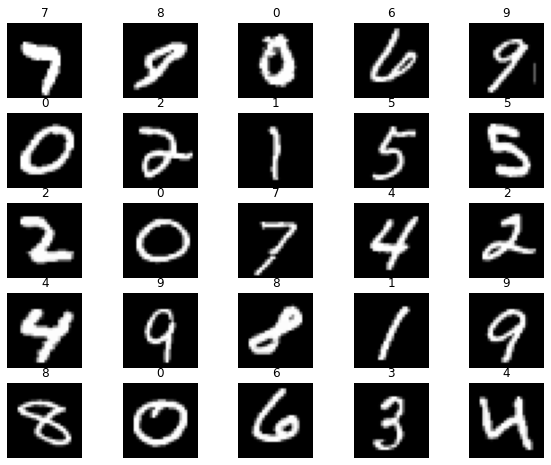

In [3]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f14ec8ee5d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f14ec82d090>}

In [5]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

loss_func = nn.CrossEntropyLoss()   
loss_func

from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [6]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
      

 
train(num_epochs, cnn, loaders)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [100/600], Loss: 0.0607
Epoch [1/10], Step [200/600], Loss: 0.0482
Epoch [1/10], Step [300/600], Loss: 0.0884
Epoch [1/10], Step [400/600], Loss: 0.1179
Epoch [1/10], Step [500/600], Loss: 0.0614
Epoch [1/10], Step [600/600], Loss: 0.0973
Epoch [2/10], Step [100/600], Loss: 0.0346
Epoch [2/10], Step [200/600], Loss: 0.0201
Epoch [2/10], Step [300/600], Loss: 0.0295
Epoch [2/10], Step [400/600], Loss: 0.0204
Epoch [2/10], Step [500/600], Loss: 0.0618
Epoch [2/10], Step [600/600], Loss: 0.0910
Epoch [3/10], Step [100/600], Loss: 0.0771
Epoch [3/10], Step [200/600], Loss: 0.0369
Epoch [3/10], Step [300/600], Loss: 0.0814
Epoch [3/10], Step [400/600], Loss: 0.0327
Epoch [3/10], Step [500/600], Loss: 0.0084
Epoch [3/10], Step [600/600], Loss: 0.0805
Epoch [4/10], Step [100/600], Loss: 0.0175
Epoch [4/10], Step [200/600], Loss: 0.1127
Epoch [4/10], Step [300/600], Loss: 0.0312
Epoch [4/10], Step [400/600], Loss: 0.0295
Epoch [4/10], Step [500/600], Loss: 0.0451
Epoch [4/10

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
test()

In [43]:
cnn.eval()
with torch.no_grad():
  for images, labels in loaders['test']:
    cond_list = []
    for image in images:
      jaco = torch.autograd.functional.jacobian(cnn, image.unsqueeze(0))
      print(jaco[0].size())
      new_jaco = torch.flatten(jaco[0], start_dim=2)
      print(new_jaco[0].size())
      cond = torch.linalg.cond(new_jaco[0])
      print(cond.size())
      print(cond)
      cond_list.append(torch.max(cond)) 
    break;

torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(7.7782)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(5.4562)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(5.1821)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(4.8136)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(5.3734)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(4.8062)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(6.0444)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(7.9452)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(4.2102)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(8.1357)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784])
torch.Size([])
tensor(6.4675)
torch.Size([1, 10, 1, 1, 28, 28])
torch.Size([10, 784]

NameError: ignored

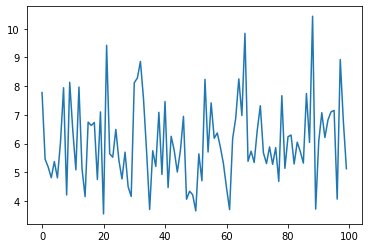

In [44]:
plt.plot(cond_list)